# READ DATASET & PRINT DATA TABLE

In [29]:
import pandas as pd
import sklearn.datasets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

dataFrame = pd.read_csv('heart_2020_cleaned.csv', sep=',')
label = 'HeartDisease'
feature_names = dataFrame.columns

#dataFrame.head()
dataFrame.tail()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
319790,Yes,27.41,Yes,No,No,7.0,0.0,Yes,Male,60-64,Hispanic,Yes,No,Fair,6.0,Yes,No,No
319791,No,29.84,Yes,No,No,0.0,0.0,No,Male,35-39,Hispanic,No,Yes,Very good,5.0,Yes,No,No
319792,No,24.24,No,No,No,0.0,0.0,No,Female,45-49,Hispanic,No,Yes,Good,6.0,No,No,No
319793,No,32.81,No,No,No,0.0,0.0,No,Female,25-29,Hispanic,No,No,Good,12.0,No,No,No
319794,No,46.56,No,No,No,0.0,0.0,No,Female,80 or older,Hispanic,No,Yes,Good,8.0,No,No,No


# DIMENSIONS (#rows, #cols)

In [ ]:
shape = dataFrame.shape
print(f'Tupel: #{shape[0]} Features: #{shape[1]}')

# DATA DISTRIBUTION (based on label)
## Histogram

In [ ]:
%matplotlib inline
dataFrame[label].hist(bins=10)

## In Numbers

In [ ]:
dataFrame[label].value_counts()

## Pairplot
**Detailed distribution of the features in the dataset. TIME CONSUMING**

In [ ]:
sns.pairplot(data=dataFrame, hue=label)
plt.show()

# DATA QUALITY CHECK
## Empty Data (None, numpy.NaN, '', numpy.inf)

**checking if there is corrupt data in a column!** 

> example:   
> feature1 0 => means no nullable data found for feature1 </br>
> feature2 5 => means 5 cells were null! -> get rid of them
            
isnull(): _"Return a boolean same-sized object indicating if the values are NA. NA values, such as None or numpy.NaN, gets mapped to True values. Everything else gets mapped to False values. Characters such as empty strings '' or numpy.inf are not considered NA values (unless you set pandas.options.mode.use_inf_as_na = True)." ~ Documentation_


In [ ]:
pd.options.mode.use_inf_as_na = True
dataFrame.isnull().sum()

## Zero Values

**doesn't always need to be a bad sign!**

GOOD: GivenBirths:0 // is OK, a woman doesn't need to give birth

BAD: Age:0 // is not OK when recording patients who died from dementia

In [ ]:
# Display how many 0 value each feature has
for field in dataFrame.columns:
    print('Number of 0-entries for "{field_name}" feature: {amount}'.format(
        field_name=field,
        amount=np.count_nonzero(dataFrame[field] == 0)
    ))

# Correlation Matrix

A matrix of correlations provides useful insight into relationships between pairs of variables.

In [ ]:
feature_names = dataFrame.columns
X = dataFrame[feature_names]
y = dataFrame[label]

sns.heatmap(
    data=X.corr(),
    annot=True,
    fmt='.2f',
    cmap='RdYlGn'
)

fig = plt.gcf()
fig.set_size_inches(10, 8)

plt.show()

# DOWNSAMPLING 
for a balanced dataset, it has to be down/upcycled 

## Pie chart - Show the im/balance

In [ ]:
print(dataFrame[label].value_counts())
dataFrame.groupby(label).size().plot(kind='pie',
                                       y = label,
                                       label = "HeartDisease",
                                       autopct='%1.1f%%')

## Actual Downsampling

In [30]:
from sklearn.utils import resample

noHeartDiseases = dataFrame[dataFrame[label] == "No"]
withHeartDiseases  = dataFrame[dataFrame[label] == "Yes"]

noHeartDiseaseDownsample = resample(noHeartDiseases,
             replace=True,
             n_samples=len(withHeartDiseases),
             random_state=42) 
    
dataFrame = pd.concat([noHeartDiseaseDownsample, withHeartDiseases])

## Pie chart - Check the balance again

In [ ]:
dataFrame.groupby(label).size().plot(kind='pie',
                                       y = label,
                                       label = "HeartDisease",
                                       autopct='%1.1f%%')
dataFrame[label].value_counts()

## Check the Data Quality again
### Empty Data Check

In [ ]:
pd.options.mode.use_inf_as_na = True
dataFrame.isnull().sum()

## Zero Values

In [ ]:
# Display how many 0 value each feature has
for field in dataFrame.columns:
    print('Number of 0-entries for "{field_name}" feature: {amount}'.format(
        field_name=field,
        amount=np.count_nonzero(dataFrame[field] == 0)
    ))

# DATA PREPARATION
## Transform Strings into Numbers

In [ ]:
dataFrame.head()

In [31]:
obj_list = dataFrame.select_dtypes(include='object').columns

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for obj in obj_list:
        dataFrame[obj] = le.fit_transform(dataFrame[obj].astype(str))
        
dataFrame.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
133490,0,26.54,1,1,0,0.0,0.0,0,1,6,5,0,1,0,7.0,0,0,0
160740,0,18.56,0,0,0,0.0,0.0,0,0,4,2,0,1,2,8.0,0,0,0
144281,0,26.37,0,0,0,21.0,0.0,0,0,4,3,0,1,1,6.0,0,0,0
283354,0,31.32,1,0,0,2.0,2.0,0,0,9,2,0,1,1,6.0,0,0,0
131213,0,36.62,1,0,0,0.0,0.0,0,1,10,5,0,1,2,6.0,0,0,0


In [ ]:
featureNames = dataFrame.columns
xd = dataFrame[featureNames]
yd = dataFrame[label]

sns.heatmap(
    data=xd.corr(),
    annot=True,
    fmt='.2f',
    cmap='RdYlGn'
)

fig = plt.gcf()
fig.set_size_inches(15, 15)

plt.show()

# ALGORITHMS

## Splitting into Test & Training Data

In [ ]:
from sklearn.model_selection import train_test_split

X = dataFrame.drop(label, axis=1).values #Feature Values
y = dataFrame[label].values #heartDiseaseValues

np.random.seed(41)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

## KNN ~71%

>1, train: 0.997, test: 0.669
>2, train: 0.829, test: 0.647
>3, train: 0.837, test: 0.696
>4, train: 0.796, test: 0.682
>5, train: 0.801, test: 0.712
>6, train: 0.784, test: 0.702
>7, train: 0.786, test: 0.722
>8, train: 0.775, test: 0.714
>9, train: 0.778, test: 0.730


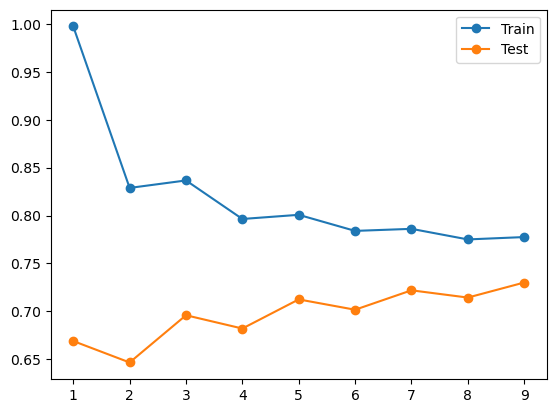

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

train_scores, test_scores = list(), list()
iterations = [i for i in range(1, 10)]

for i in iterations:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    #knn.score(X_test, y_test)
    
    trainPrediction = knn.predict(X_train)
    trainAccuracy = accuracy_score(y_train, trainPrediction)
    train_scores.append(trainAccuracy)
    
    testPrediction = knn.predict(X_test)
    testAccuracy = accuracy_score(y_test, testPrediction)
    test_scores.append(testAccuracy)
    print('>%d, train: %.3f, test: %.3f' % (i, trainAccuracy, testAccuracy))
    
pyplot.plot(iterations, train_scores, '-o', label='Train')
pyplot.plot(iterations, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()

## Check if Overfitted
taking a look onto the difference between the accuracy score of the training and the test data
Wide difference? -> Overfitted!

In [35]:
from sklearn.metrics import accuracy_score
trainPrediction = knn.predict(X_train)
trainAccuracy = accuracy_score(trainPrediction, y_train)

testPrediction = knn.predict(X_test)
testAccuracy = accuracy_score(testPrediction, y_test)

print(trainAccuracy)
print(testAccuracy)

C:\Program Files\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Program Files\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepd

0.8007352269613663
0.7124200913242009


## Logistic Regression ~75% Aber mit Fehlermeldung

In [33]:
from sklearn.linear_model import LogisticRegression
np.random.seed(41)
lr = LogisticRegression().fit(X_train, y_train)
lr.score(X_test, y_test)

C:\Program Files\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7518721461187214

## Random Forest Classifier ~75%

In [34]:
from sklearn.ensemble import RandomForestClassifier
np.random.seed(41)
rf = RandomForestClassifier().fit(X_train, y_train)
rf.score(X_test, y_test)

0.7522374429223744

## Decision Tree Classifier ~70%

>1, train: 0.679, test: 0.689
>2, train: 0.711, test: 0.720
>3, train: 0.720, test: 0.722
>4, train: 0.742, test: 0.742
>5, train: 0.745, test: 0.747
>6, train: 0.751, test: 0.752
>7, train: 0.754, test: 0.752
>8, train: 0.763, test: 0.758
>9, train: 0.768, test: 0.756
>10, train: 0.777, test: 0.754
>11, train: 0.785, test: 0.745
>12, train: 0.796, test: 0.742
>13, train: 0.809, test: 0.737
>14, train: 0.824, test: 0.733
>15, train: 0.840, test: 0.724
>16, train: 0.857, test: 0.717
>17, train: 0.875, test: 0.710
>18, train: 0.891, test: 0.709
>19, train: 0.907, test: 0.705
>20, train: 0.921, test: 0.698


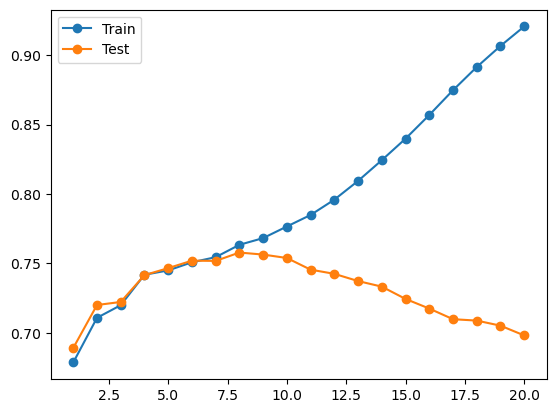

Score:
0.6980821917808219


In [45]:
from sklearn.tree import DecisionTreeClassifier

train_scores, test_scores = list(), list()
# define the tree depths to evaluate
iterations = [i for i in range(1, 21)]
# evaluate a decision tree for each depth
for i in iterations:
	# configure the model
	model = DecisionTreeClassifier(max_depth=i)
	# fit model on the training dataset
	model.fit(X_train, y_train)
	# evaluate on the train dataset
	trainPrediction = model.predict(X_train)
	trainAccuracy = accuracy_score(y_train, trainPrediction)
	train_scores.append(trainAccuracy)
	# evaluate on the test dataset
	testPrediction = model.predict(X_test)
	testAccuracy = accuracy_score(y_test, testPrediction)
	test_scores.append(testAccuracy)
	# summarize progress
	print('>%d, train: %.3f, test: %.3f' % (i, trainAccuracy, testAccuracy))
# plot of train and test scores vs tree depth
pyplot.plot(iterations, train_scores, '-o', label='Train')
pyplot.plot(iterations, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()
print("Score:")
print(model.score(X_test, y_test))